$$\mbox{Integer Programming}$$


We are going to use Julia. There are different options to do that.
- You can install Julia on your computer (you might need an editor such as atom) and execute evrything locally. You can just copy some parts of the code given in the html file.
- In addition to that, you can also install jupyter on your machine and then open the file *.ipynb
- Use google colab, in this case, you need to have a google account (and you d'ont need to install Julia). The file is stored on the Google drive, and programs are executed on a virtual machine.  You have to open the *.ipynb and run the installation cell below.

In [ ]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU).

<br/>You should see something like this:

> ![Colab Img](https://raw.githubusercontent.com/Dsantra92/Julia-on-Colab/master/misc/julia_menu.png)

<br/>Click on SAVE
<br/>**We are ready to get going**





In [ ]:
VERSION


v"1.7.2"

In [ ]:
import Pkg

Pkg.add("JuMP")

Pkg.add("GLPK")
Pkg.add("Random")
Pkg.add("Graphs")
Pkg.add("GraphPlot")
Pkg.add("Compose")
Pkg.add("Cairo")
Pkg.add("Combinatorics")
using GraphPlot, Compose, Cairo, Graphs, Combinatorics

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IrrationalConstants ── v0.2.2
   Installed Bzip2_jll ──────────── v1.0.8+4
   Installed CodecBzip2 ─────────── v0.8.5
   Installed DiffResults ────────── v1.1.0
   Installed DiffRules ──────────── v1.15.1
   Installed BenchmarkTools ─────── v1.6.0
   Installed SpecialFunctions ───── v2.5.0
   Installed MutableArithmetics ─── v1.6.2
   Installed StaticArraysCore ───── v1.4.3
   Installed NaNMath ────────────── v1.0.3
   Installed OrderedCollections ─── v1.7.0
   Installed TranscodingStreams ─── v0.11.3
   Installed StaticArrays ───────── v1.9.10
   Installed ForwardDiff ────────── v0.10.38
   Installed ChainRulesCore ─────── v1.25.1
   Installed JuMP ───────────────── v1.23.6
   Installed OpenSpecFun_jll ────── v0.5.6+0
   Installed CommonSubexpressions ─ v0.3.1
   Installed LogExpFunctions ────── v0.3.28
   Installed Compat ─────────────── v4.16.0
   Installed InverseFunctions ────

# Some allocation problem

A marble producing company recieves $m$ orders $O_1,...,O_m$ each order demands a minimum amount of marble $d_1,...,d_m$ in terms of weight. The company owns $n$ finished prodcuts $P_1,...,P_n$. Let $w_1,...,w_n$ be the weigths of the products. The company wants to allocate products to orders in order to satisfy all demands, while minimizing the total  allocated material (that exceeds the demand). Solve this problem via a MILP

In [ ]:
#@title Allocation model
using JuMP
using GLPK
function product_order_allocation(w, d, n,m)

model=Model(GLPK.Optimizer)

@variable(model, x[1:n,1:m], Bin)

@constraint(model,demsat_j[j in  1:m], sum(x[i,j]*w[i] for i in 1:n) >=d[j])

@constraint(model,noubiq_i[i in 1:n],sum(x[i,j] for j in 1:m)<= 1)

@objective(model, Min, sum(x[i,j]*w[i] for j in 1:m, i in 1:n))

#print(model)

optimize!(model)

if (termination_status(model)== MOI.OPTIMAL)
for i in 1:n
  for j in 1:m
    println(" x[", i,j, "] = ",  value(x[i,j]))
  end
 end
     return objective_value(model)
else
    println("Problem has not an optimal solution")
    return -1
end

return objective_value(model)
end

product_order_allocation (generic function with 1 method)

Let us create an instance of such a problem.

In [ ]:
global n=5
global m = 3
global w = zeros(Float64,n,1)
global d = zeros(Float64,m,1)

w = [ 2 3 4 5 6]
d = [4 7 1]

product_order_allocation(w, d, n,m)

 x[11] = 0.0
 x[12] = 0.0
 x[13] = 1.0
 x[21] = 0.0
 x[22] = 1.0
 x[23] = 0.0
 x[31] = 1.0
 x[32] = 0.0
 x[33] = 0.0
 x[41] = 0.0
 x[42] = 1.0
 x[43] = 0.0
 x[51] = 0.0
 x[52] = 0.0
 x[53] = 0.0


14.0

Suppose that order $O_1$  has a further requirement: if product $P_3$ is assigned to $O_1$, then it must be assigned also product $P_1$ and $P_2$. How
to model this constraint?


In [ ]:
#@title Product order allocation 2
function product_order_allocation_2(w, d, n,m)

model=Model(GLPK.Optimizer)

@variable(model, x[1:n,1:m], Bin)

@constraint(model,demsat_j[j in  1:m], sum(x[i,j]*w[i] for i in 1:n) >=d[j])

@constraint(model,noubiq_i[i in 1:n],sum(x[i,j] for j in 1:m)<= 1)

#@constraint(model,x[3,1]<= x[2,1] + x[1,1])
@constraint(model,x[3,1]<= x[1,1])
@constraint(model,x[3,1]<= x[2,1])

@objective(model, Min, sum(x[i,j]*w[i] for j in 1:m, i in 1:n))

#print(model)

optimize!(model)

if (termination_status(model)== MOI.OPTIMAL)

for i in 1:n
  for j in 1:m
    println(" x[", i,j, "] = ",  value(x[i,j]))
  end
 end
   return objective_value(model)
else
    println("Problem has not an optimal solution")
    return -1
end

return objective_value(model)
end

product_order_allocation_2 (generic function with 1 method)

Let's run again on the same input

In [ ]:
product_order_allocation_2(w, d, n,m)

 x[11] = 0.0
 x[12] = 0.0
 x[13] = 1.0
 x[21] = 0.0
 x[22] = 1.0
 x[23] = 0.0
 x[31] = 0.0
 x[32] = 1.0
 x[33] = 0.0
 x[41] = 1.0
 x[42] = 0.0
 x[43] = 0.0
 x[51] = 0.0
 x[52] = 0.0
 x[53] = 0.0


14.0

*BIN* PACKING
A company must deliver products $P_1,...,P_n$ of weight $w_1,...,w_n$ by renting some of the available trucks $T_1,...,T_n$: each truck has a maximum weight load  $L$, with $L\ge w_1,...,w_n$.  
Formulate the problem of finding the minimum number of trucks to rent as a MILP.


In [ ]:
#BIN PACKING
using JuMP
using GLPK
function bin_packing(w, n, L)

model=Model(GLPK.Optimizer)

@variable(model, x[1:n,1:n], Bin)

@variable(model, y[1:n], Bin)

@constraint(model,maxload[j in  1:n], sum(x[i,j]*w[i] for i in 1:n) <= y[j]*L)

@constraint(model,noubiq_i[i in 1:n],sum(x[i,j] for j in 1:n) == 1)

@objective(model, Min, sum(y[j] for j in 1:n))

#print(model)

optimize!(model)

if (termination_status(model)== MOI.OPTIMAL)
for i in 1:n
  for j in 1:n
    if (value(x[i,j])==1)
      println(" x[", i,j, "] = ",  value(x[i,j]))
    end
  end
end

for j in 1:n
  println(" y[",j, "] = ",  value(y[j]))
end


     return objective_value(model)
else
    println("Problem has not an optimal solution")
    return -1
end

return objective_value(model)
end

bin_packing (generic function with 1 method)

In [ ]:
global n=60
using Random
Random.seed!(123)
global w = 1:n#costs=10*rand(n)
L=87
bin_packing(w, n,L)

 x[121] = 1.0
 x[260] = 1.0
 x[360] = 1.0
 x[410] = 1.0
 x[510] = 1.0
 x[68] = 1.0
 x[710] = 1.0
 x[89] = 1.0
 x[911] = 1.0
 x[1021] = 1.0
 x[115] = 1.0
 x[126] = 1.0
 x[1310] = 1.0
 x[1423] = 1.0
 x[151] = 1.0
 x[168] = 1.0
 x[1721] = 1.0
 x[1817] = 1.0
 x[199] = 1.0
 x[203] = 1.0
 x[213] = 1.0
 x[226] = 1.0
 x[231] = 1.0
 x[244] = 1.0
 x[254] = 1.0
 x[264] = 1.0
 x[2718] = 1.0
 x[285] = 1.0
 x[2920] = 1.0
 x[3019] = 1.0
 x[3116] = 1.0
 x[323] = 1.0
 x[3323] = 1.0
 x[3411] = 1.0
 x[3522] = 1.0
 x[3614] = 1.0
 x[3760] = 1.0
 x[3815] = 1.0
 x[391] = 1.0
 x[4023] = 1.0
 x[4113] = 1.0
 x[4212] = 1.0
 x[4360] = 1.0
 x[4411] = 1.0
 x[4512] = 1.0
 x[4613] = 1.0
 x[475] = 1.0
 x[4815] = 1.0
 x[4914] = 1.0
 x[506] = 1.0
 x[5122] = 1.0
 x[5216] = 1.0
 x[5310] = 1.0
 x[548] = 1.0
 x[5518] = 1.0
 x[5617] = 1.0
 x[5719] = 1.0
 x[5820] = 1.0
 x[5921] = 1.0
 x[609] = 1.0
 y[1] = 1.0
 y[2] = 0.0
 y[3] = 1.0
 y[4] = 1.0
 y[5] = 1.0
 y[6] = 1.0
 y[7] = 0.0
 y[8] = 1.0
 y[9] = 1.0
 y[10] = 1.0
 y[11] = 

22.0

ALLOCATION PROBLEM There are $n$ students $S_1,...,S_n$ that have to choose their advisor among $k$ available teachers $T_1,...,T_k$ with $k\ge n$. Every student $S_i$ has a preference mark $p_{ij}$ for every teacher $T_j$, with $0\le p_{ij} \le 20$. Every teacher can supervise no more than $4$ students. Moreover  student $S_1$ and $S_2$ want necessarily to have the same teacher; teacher $T_1$ can advise student $S_3$ only if he advises also student $S_4$; teacher $T_2$ can only advise an even number of students. An assignment of every student to a teacher, maximizing the total sum of preferences, is seeked.

In [ ]:
#@title Students teachers allocation
function students_teachers_allocation(P, n, m)

  model=Model(GLPK.Optimizer)

  @variable(model, x[1:n,1:m], Bin)

  @variable(model, z, Int)

  @constraint(model,moin4_j[j in  1:m], sum(x[i,j] for i in 1:n) <= 4)

  @constraint(model,assign_i[i in 1:n],sum(x[i,j] for j in 1:m) == 1)

  @constraint(model,s1s2_j[j in  1:m],x[1,j]  == x[2,j])

  @constraint(model,T3,x[3,1]<=x[4,1])

  @constraint(model,evenT2,sum(x[i,2] for i in 1:n)==2*z)

  @objective(model, Max, sum(x[i,j]*P[i,j] for j in 1:m, i in 1:n))

  #print(model)

  optimize!(model)


  if (termination_status(model)== MOI.OPTIMAL)
    println("Solution optimale : ")

    for i in 1:n
      for j in 1:m
        println(" x[", i,j, "] = ",  value(x[i,j]))
      end
    end

    return objective_value(model)
  else
    println("Problem has not an optimal solution")
    return -1
  end
end

students_teachers_allocation (generic function with 1 method)

In [ ]:
global n=5
global m = 2
global P = zeros(Float64,n,m)

P = [13 15
    11 20
    9 18
    14 19
    13 16]


students_teachers_allocation(P, n, m)

Solution optimale : 
 x[11] = 0.0
 x[12] = 1.0
 x[21] = 0.0
 x[22] = 1.0
 x[31] = 0.0
 x[32] = 1.0
 x[41] = 0.0
 x[42] = 1.0
 x[51] = 1.0
 x[52] = 0.0


85.0

# TSP

The (asymmetric) Travelling Salesman Problem (TSP) is the following: Given a complete directed graph $G=(V,E)$ and a cost function $c$ on the edges, find the cheapest cost hamiltonian cycle.




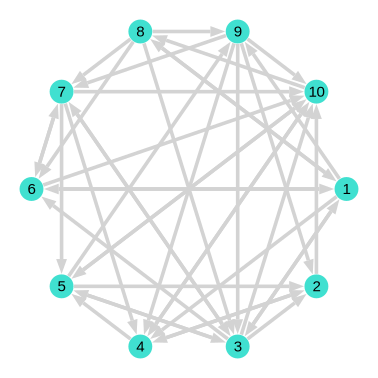

In [ ]:
#collect(powerset([:10]))
nG=10
#nA=30
D = erdos_renyi(nG, 0.4, is_directed=true, seed=123)
gplot(D,layout=circular_layout,nodelabel=collect(1:nv(D)))
#v = 1:nG
#S=collect(powerset(1:5))
#costs =  rand(nG, nG)
#S[22]

$$\min \sum_{e\in E} x_ec_e$$
$$\forall i \in V \ \ \ \ \ \ \sum_{e \in\Gamma^-(i)}x_e=1$$
$$\forall i \in V \ \ \ \ \ \ \sum_{e \in\Gamma^+(i)}x_e=1$$
$$\forall S \subsetneq V, |S| \ge 2 \ \ \ \ \ \ \sum_{e \in E(S)}x_e \le |S|-1$$
We write a model to solve TSP

In [ ]:
using JuMP
using GLPK
function TSP(D,c)

#creates the subset of vertices for subtour elimination constraints (namely those of 2<= size <=n-1 )
startcyc= 1 + nv(D) + 1
endcyc= 2^(nv(D)) - 1#nv(D)
allsubsets=collect(powerset(1:nv(D)))
restricted_subsets=allsubsets[startcyc:endcyc]

model=Model(GLPK.Optimizer)

@variable(model, x[1:ne(D)],Bin)
#@constraint(model, bornes[e in 1:ne(D)], 0<=x[e]<=1)
#for every i: sum_{edges e such that i is the source of e} x(e) = 1
@constraint(model,outdegree1[i in 1:nv(D)], sum(x[e]*(Int(i==src(collect(edges(D))[e])))
for e in 1:ne(D) ) == 1 )
#for every i: sum_{edges e such that i is the destination of e} x(e) = 1
@constraint(model,indegree1[i in 1:nv(D)], sum(x[e]*(Int(i==dst(collect(edges(D))[e])))
for e in 1:ne(D) ) == 1 )

#subtour elimination constraints
@constraint(model,subtour_elimination[s in restricted_subsets], sum( x[e] * Int(src(collect(edges(D))[e]) in s)*Int(dst(collect(edges(D))[e]) in s)
for e in 1:ne(D)) <= length(s) - 1 )

@objective(model, Min, sum(x[e]*c[e] for e in 1:ne(D)))

optimize!(model)

if (termination_status(model)== MOI.OPTIMAL)
global Tour = SimpleDiGraph(nv(D))
  for e in 1:ne(D)
    if value(x[e])!= 0
      println(" x[", e, "] = ",  "(",src(collect(edges(D))[e]), ", " , dst(collect(edges(D))[e]), ") ")
      add_edge!(Tour, collect(edges(D))[e])
    end
  end
  return objective_value(model)
else
    println("Problem has not an optimal solution")
    return -1
end

println( objective_value(model) )
obj=0;
#calculates the objective value in the original costs
for e in 1:ne(D)
  obj = obj + costs[e]*value(x[e])
end

return obj

end

TSP (generic function with 1 method)

Let us solve TSP on $D$ with a random cost $0\le c \le 10$ on the arcs

In [ ]:
using Random
Random.seed!(124)
costs=10*rand(ne(D))
TSP(D,costs)


#cyc = simplecycles(Tour)

 x[3] = (1, 6) 
 x[7] = (2, 10) 
 x[8] = (3, 1) 
 x[15] = (4, 5) 
 x[19] = (5, 9) 
 x[22] = (6, 7) 
 x[25] = (7, 4) 
 x[30] = (8, 3) 
 x[34] = (9, 2) 
 x[41] = (10, 8) 


35.0757174865033

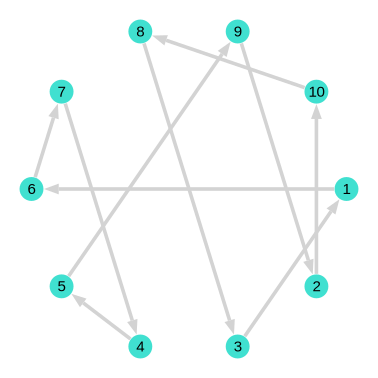

In [ ]:
gplot(Tour,layout=circular_layout,nodelabel=collect(1:nv(Tour)))

# Independent set and Vertex Cover

Here is the MILP model of independent set

In [ ]:
#@title Maximum Independet Set model
using JuMP
using GLPK
function max_indep_set(H)

model=Model(GLPK.Optimizer)

@variable(model, x[1:nv(H)], Bin)

#for every edge the two endpoints must not be both in the chosen se
@constraint(model,independence[e in 1:ne(H)], x[src(collect(edges(H))[e])] + x[dst(collect(edges(H))[e])] <= 1 )


@objective(model, Max, sum(x[i] for i in 1:nv(H)))

optimize!(model)

if (termination_status(model)== MOI.OPTIMAL)
for i in 1:nv(H)
    println(" x[", i, "] = ",  value(x[i]))
 end
     return objective_value(model)
else
    println("Problem has not an optimal solution")
    return -1
end

return objective_value(model)
end

max_indep_set (generic function with 1 method)

Let us build a random graph

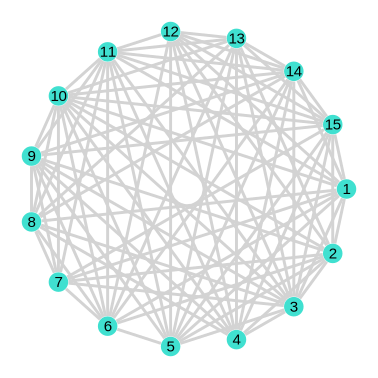

In [ ]:
G = erdos_renyi(15, 0.7, seed=12)
gplot(G,layout=circular_layout,nodelabel=collect(1:nv(G)))

In [ ]:
max_indep_set(G)


 x[1] = 1.0
 x[2] = 0.0
 x[3] = 0.0
 x[4] = 0.0
 x[5] = 0.0
 x[6] = 0.0
 x[7] = 0.0
 x[8] = 0.0
 x[9] = 1.0
 x[10] = 0.0
 x[11] = 0.0
 x[12] = 0.0
 x[13] = 1.0
 x[14] = 0.0
 x[15] = 0.0


3.0

In [ ]:
#@title Min Vertex Cover model
using JuMP
using GLPK
function min_vertex_cover(H)

model=Model(GLPK.Optimizer)

@variable(model, x[1:nv(H)], Bin)

#for every edge at least one of the endpoints must be chosen
@constraint(model,independence[e in 1:ne(H)], x[src(collect(edges(H))[e])] + x[dst(collect(edges(H))[e])] >= 1 )


#@constraint(model,noubiq_i[i in 1:n],sum(x[i,j] for j in 1:m)<= 1)

@objective(model, Min, sum(x[i] for i in 1:nv(H)))

optimize!(model)

if (termination_status(model)== MOI.OPTIMAL)
#for i in 1:nv(H)
## println(" x[", i, "] = ",  value(x[i]))
# end
     return objective_value(model)
else
    println("Problem has not an optimal solution")
    return -1
end

return objective_value(model)
end

min_vertex_cover (generic function with 1 method)

In [ ]:
count=0
for i in 1:2000
  G = erdos_renyi(15, 0.7)
  count = count+ max_indep_set(G)
end
avg=count/2000


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 x[11] = 0.0
 x[12] = 1.0
 x[13] = 0.0
 x[14] = 0.0
 x[15] = 1.0
 x[1] = 0.0
 x[2] = 1.0
 x[3] = 1.0
 x[4] = 0.0
 x[5] = 0.0
 x[6] = 1.0
 x[7] = 0.0
 x[8] = 0.0
 x[9] = 0.0
 x[10] = 1.0
 x[11] = 0.0
 x[12] = 0.0
 x[13] = 0.0
 x[14] = 0.0
 x[15] = 0.0
 x[1] = 0.0
 x[2] = 1.0
 x[3] = 0.0
 x[4] = 0.0
 x[5] = 0.0
 x[6] = 0.0
 x[7] = 0.0
 x[8] = 0.0
 x[9] = 0.0
 x[10] = 1.0
 x[11] = 0.0
 x[12] = 0.0
 x[13] = 1.0
 x[14] = 0.0
 x[15] = 0.0
 x[1] = 1.0
 x[2] = 0.0
 x[3] = 1.0
 x[4] = 0.0
 x[5] = 1.0
 x[6] = 0.0
 x[7] = 0.0
 x[8] = 0.0
 x[9] = 0.0
 x[10] = 0.0
 x[11] = 0.0
 x[12] = 0.0
 x[13] = 0.0
 x[14] = 0.0
 x[15] = 0.0
 x[1] = 0.0
 x[2] = 1.0
 x[3] = 0.0
 x[4] = 0.0
 x[5] = 1.0
 x[6] = 0.0
 x[7] = 0.0
 x[8] = 0.0
 x[9] = 0.0
 x[10] = 0.0
 x[11] = 0.0
 x[12] = 0.0
 x[13] = 0.0
 x[14] = 0.0
 x[15] = 1.0
 x[1] = 0.0
 x[2] = 0.0
 x[3] = 1.0
 x[4] = 0.0
 x[5] = 0.0
 x[6] = 1.0
 x[7] = 1.0
 x[8] = 0.0
 x[9] = 1.0
 x[10

3.478

In [ ]:
avg

6.919